In [1]:
# Necessary imports
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
%matplotlib inline

In [2]:
## Unpickle main dataframe
df = pd.read_pickle('data/combined_df.pkl')

In [3]:
## Only use average happiness
smaller_df = df.drop(['happiness_2018', 'happiness_2017', 'happiness_2016'], axis = 1)

In [4]:
## Examine the columns, look at missing data
smaller_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 9 columns):
air_quality           50 non-null float64
rel_humidity          50 non-null float64
avg_num_clear_days    50 non-null float64
pct_area_water        50 non-null float64
rainfall_inches       50 non-null float64
temp_f                50 non-null float64
highest_point_ft      50 non-null float64
mean_elevation_ft     50 non-null float64
happiness_avg         50 non-null float64
dtypes: float64(9)
memory usage: 3.9+ KB


In [5]:
smaller_df.describe()

,air_quality,rel_humidity,avg_num_clear_days,pct_area_water,rainfall_inches,temp_f,highest_point_ft,mean_elevation_ft,happiness_avg
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.00000,50.000000
mean,42.214000,52.380000,103.260000,8.320000,37.078000,51.944000,6164.280000,1779.80000,58.611000
std,5.261683,8.419826,27.837583,10.246234,14.635898,8.706581,5087.439611,1824.94114,3.411375
min,21.200000,25.000000,58.000000,0.200000,9.500000,26.600000,345.000000,60.00000,50.370000
25%,39.525000,50.000000,89.250000,1.625000,24.525000,45.250000,2059.750000,600.00000,57.070000
50%,43.550000,53.500000,100.500000,3.300000,41.750000,51.200000,4589.500000,1000.00000,58.715000
75%,45.900000,58.000000,115.000000,12.750000,47.850000,58.650000,10624.500000,2150.00000,60.680000
max,51.200000,64.000000,193.000000,41.500000,63.700000,70.700000,20310.000000,6800.00000,65.620000


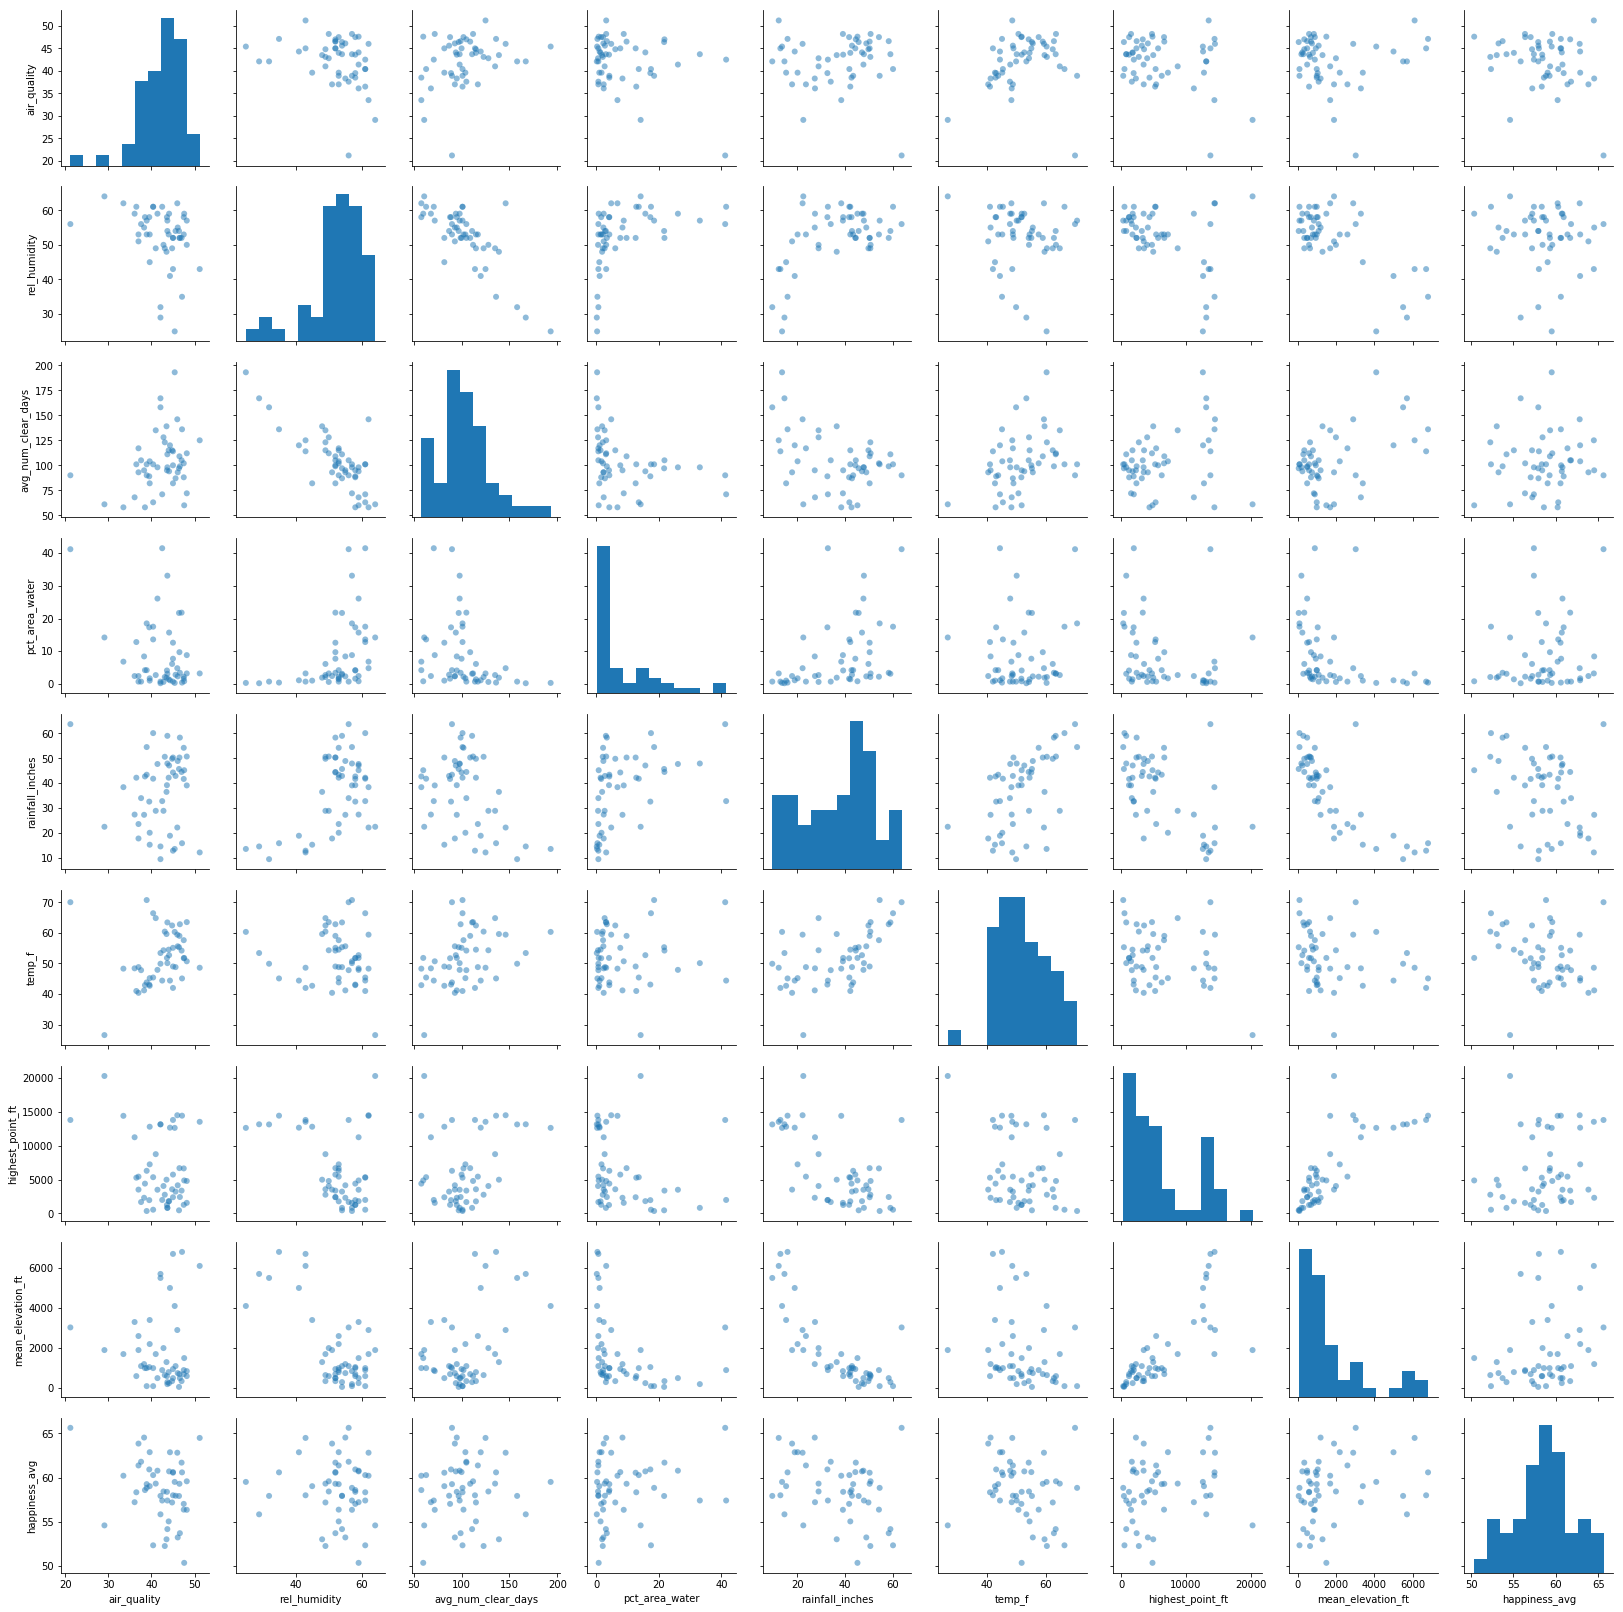

In [10]:
sns.pairplot(smaller_df, plot_kws=dict(alpha=.5, edgecolor='none'))

In [6]:
#Separate our features from our target

X = smaller_df.loc[:,['air_quality', 'rel_humidity', 'avg_num_clear_days', 
                      'pct_area_water', 'rainfall_inches', 'temp_f', 
                      'highest_point_ft', 'mean_elevation_ft']]

y = smaller_df['happiness_avg']

# Add polynomial and Interaction terms

In [7]:
X2 = X.copy()

X2['HM__x__RF'] = X2['rel_humidity'] * X2['rainfall_inches']
X2['TM__x__RF'] = X2['temp_f'] * X2['rainfall_inches']
X2['HP__x__ME'] = X2['highest_point_ft'] * X2['mean_elevation_ft']



In [8]:
lr_model = LinearRegression()
lr_model.fit(X2, y)
for feature, coef in zip(X2.columns, lr_model.coef_):
        print(feature, ':', f'{coef:.2f}')

air_quality : -0.17
rel_humidity : 0.27
avg_num_clear_days : 0.01
pct_area_water : 0.14
rainfall_inches : 0.67
temp_f : 0.18
highest_point_ft : -0.00
mean_elevation_ft : 0.00
HM__x__RF : -0.01
TM__x__RF : -0.00
HP__x__ME : -0.00


In [9]:
lr_model.score(X2, y)

0.33011591728406664

In [10]:
smaller_df['HM__x__RF'] = smaller_df['rel_humidity'] * smaller_df['rainfall_inches']
smaller_df['TM__x__RF'] = smaller_df['temp_f'] * smaller_df['rainfall_inches']
smaller_df['HP__x__ME'] = smaller_df['highest_point_ft'] * smaller_df['mean_elevation_ft']

smaller_df['pct_area_water05'] = smaller_df['pct_area_water']**0.5
smaller_df['mean_elevation05'] = smaller_df['mean_elevation_ft']**0.5
smaller_df['hp05'] = smaller_df['highest_point_ft']**0.5


In [11]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('happiness_avg ~ air_quality + rel_humidity + avg_num_clear_days + pct_area_water + rainfall_inches + temp_f + highest_point_ft + mean_elevation_ft + HM__x__RF + TM__x__RF + HP__x__ME + pct_area_water05 + mean_elevation05 + hp05', data=smaller_df, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          happiness_avg   R-squared:                       0.506
Model:                            OLS   Adj. R-squared:                  0.308
Method:                 Least Squares   F-statistic:                     2.561
Date:                Mon, 15 Apr 2019   Prob (F-statistic):             0.0121
Time:                        12:55:44   Log-Likelihood:                -114.16
No. Observations:                  50   AIC:                             258.3
Df Residuals:                      35   BIC:                             287.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             37.8053     14.243      2.654      0.012       8.891      66.720
air_quality           -0.2109      0.138     -1.526      0.136      -0.491       0.070
rel_humidity           0.1694      0.170      0.994      0.327      -0.177       0.515
avg_num_clear_days     0.0109      0.034      0.325      0.747      -0.057       0.079
pct_area_water        -0.5587      0.228     -2.449      0.019      -1.022      -0.096
rainfall_inches        0.4622      0.512      0.902      0.373      -0.578       1.503
temp_f                 0.1490      0.218      0.684      0.499      -0.293       0.591
highest_point_ft      -0.0009      0.001     -0.776      0.443      -0.003       0.001
mean_elevation_ft      0.0004      0.006      0.070      0.944      -0.011       0.012
HM__x__RF             -0.0078      0.006     -1.309      0.199      -0.020       0.004
TM__x__RF             -0.0024      0.005     -0.487      0.629      -0.012       0.008
HP__x__ME           -1.45e-08   2.88e-07     -0.050      0.960   -5.99e-07     5.7e-07
pct_area_water05       5.1909      1.681      3.087      0.004       1.777       8.604
mean_elevation05       0.1728      0.282      0.612      0.545      -0.401       0.746
hp05                   0.0810      0.137      0.592      0.558      -0.197       0.359
==============================================================================
Omnibus:                        1.749   Durbin-Watson:                   1.505
Prob(Omnibus):                  0.417   Jarque-Bera (JB):                1.685
Skew:                          -0.416   Prob(JB):                        0.431
Kurtosis:                       2.660   Cond. No.                     1.15e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [12]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('happiness_avg ~ air_quality + rel_humidity + pct_area_water + rainfall_inches + temp_f + highest_point_ft + HM__x__RF + TM__x__RF + pct_area_water05 + mean_elevation05 + hp05', data=smaller_df, return_type="dataframe")

# Create your model
model = sm.OLS(y, X)

# Fit your model to your training set
fit = model.fit()

# Print summary statistics of the model's performance
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          happiness_avg   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.361
Method:                 Least Squares   F-statistic:                     3.515
Date:                Mon, 15 Apr 2019   Prob (F-statistic):            0.00186
Time:                        12:55:46   Log-Likelihood:                -114.25
No. Observations:                  50   AIC:                             252.5
Df Residuals:                      38   BIC:                             275.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           39.0112     13.222      2.950      0.005      12.245      65.778
air_quality         -0.2122      0.103     -2.064      0.046      -0.420      -0.004
rel_humidity         0.1466      0.135      1.085      0.285      -0.127       0.420
pct_area_water      -0.5600      0.209     -2.682      0.011      -0.983      -0.137
rainfall_inches      0.4656      0.459      1.015      0.317      -0.463       1.395
temp_f               0.1796      0.170      1.059      0.296      -0.164       0.523
highest_point_ft    -0.0009      0.001     -1.687      0.100      -0.002       0.000
HM__x__RF           -0.0078      0.005     -1.451      0.155      -0.019       0.003
TM__x__RF           -0.0027      0.004     -0.615      0.542      -0.011       0.006
pct_area_water05     5.2079      1.488      3.501      0.001       2.196       8.220
mean_elevation05     0.1915      0.077      2.500      0.017       0.036       0.347
hp05                 0.0785      0.088      0.889      0.380      -0.100       0.257
==============================================================================
Omnibus:                        1.661   Durbin-Watson:                   1.515
Prob(Omnibus):                  0.436   Jarque-Bera (JB):                1.616
Skew:                          -0.402   Prob(JB):                        0.446
Kurtosis:                       2.642   Cond. No.                     2.80e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.8e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Now, let's plot residuals and a Q-Q Graph

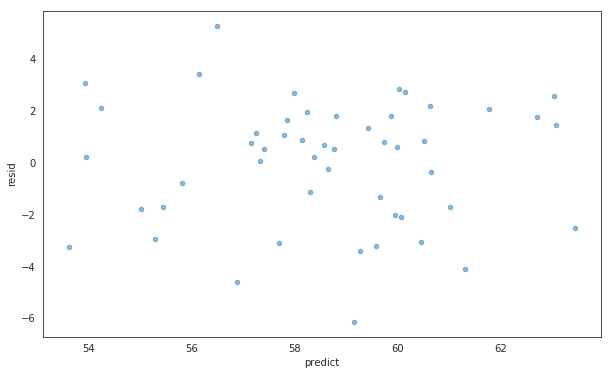

In [13]:
# Add prediction and residual columns to the dataframe
smaller_df['predict'] = fit.predict(X)
smaller_df['resid'] = smaller_df['happiness_avg'] - smaller_df.predict
with sns.axes_style('white'):
    plot = smaller_df.plot(
        kind='scatter', x='predict', y='resid', alpha=0.5, figsize=(10,6))

Text(0.5, 1.0, 'Normal Q-Q plot')

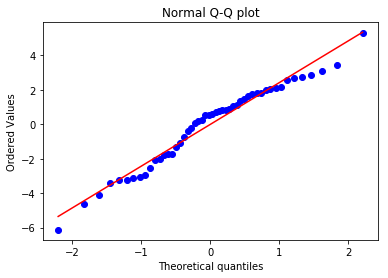

In [14]:
res = smaller_df['happiness_avg'] - smaller_df.predict

stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

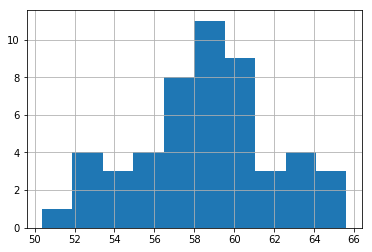

In [15]:
# create histogram of average happiness
smaller_df.happiness_avg.hist();

### Trying Boxcox 

In [16]:
lamb=stats.boxcox_normmax(smaller_df.pct_area_water, brack=(-1.9, 1.9)) # don't use "lambda" as it's a Python reserved word
print("Lambda for pct_area_water:", lamb)
# y_t=(np.power(movie.DomesticTotalGross,-0.2282)-1)/-0.2282

# plt.hist(y_t);

Lambda for pct_area_water: 0.03617845335644085


In [17]:
lamb=stats.boxcox_normmax(smaller_df.mean_elevation_ft, brack=(-1.9, 1.9)) # don't use "lambda" as it's a Python reserved word
print("Lambda for mean_elevation_ft:", lamb)

Lambda for mean_elevation_ft: 0.12508422732212937


In [18]:
lamb=stats.boxcox_normmax(smaller_df.highest_point_ft, brack=(-1.9, 1.9)) # don't use "lambda" as it's a Python reserved word
print("Lambda for highest_point_ft:", lamb)

Lambda for highest_point_ft: 0.2101576573792726


### Trying the model BoxCox exponents

In [30]:
smaller_df['pct_area_water_bc'] = smaller_df['pct_area_water']**0.036
smaller_df['mean_elevation_bc'] = (np.power(smaller_df['mean_elevation_ft'],0.125)-1)/0.125
smaller_df['hp_bc'] = (np.power(smaller_df['highest_point_ft'],0.210)-1)/0.210

In [31]:
# Create your feature matrix (X) and target vector (y)
y, X = patsy.dmatrices('happiness_avg ~ air_quality + rel_humidity + pct_area_water + rainfall_inches + temp_f + highest_point_ft + HM__x__RF + TM__x__RF + pct_area_water_bc + mean_elevation_bc + hp_bc', data=smaller_df, return_type="dataframe")

# Create your model
new_model = sm.OLS(y, X)

# Fit your model to your training set
new_fit = model.fit()

# Print summary statistics of the model's performance
new_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          happiness_avg   R-squared:                       0.474
Model:                            OLS   Adj. R-squared:                  0.321
Method:                 Least Squares   F-statistic:                     3.109
Date:                Mon, 15 Apr 2019   Prob (F-statistic):            0.00451
Time:                        15:21:23   Log-Likelihood:                -115.75
No. Observations:                  50   AIC:                             255.5
Df Residuals:                      38   BIC:                             278.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -30.1228     28.251     -1.066      0.293     -87.315      27.069
air_quality          -0.1778      0.104     -1.704      0.097      -0.389       0.033
rel_humidity         -0.0364      0.139     -0.262      0.795      -0.318       0.245
pct_area_water       -0.1211      0.098     -1.232      0.226      -0.320       0.078
rainfall_inches       0.1477      0.444      0.332      0.741      -0.752       1.047
temp_f                0.1434      0.168      0.855      0.398      -0.196       0.483
highest_point_ft     -0.0004      0.000     -1.201      0.237      -0.001       0.000
HM__x__RF            -0.0033      0.005     -0.605      0.549      -0.014       0.008
TM__x__RF            -0.0017      0.004     -0.399      0.692      -0.010       0.007
pct_area_water_bc    80.8627     25.245      3.203      0.003      29.757     131.968
mean_elevation_bc     1.0392      0.555      1.872      0.069      -0.085       2.163
hp_bc                 0.0889      0.367      0.242      0.810      -0.653       0.831
==============================================================================
Omnibus:                        1.955   Durbin-Watson:                   1.544
Prob(Omnibus):                  0.376   Jarque-Bera (JB):                1.802
Skew:                          -0.448   Prob(JB):                        0.406
Kurtosis:                       2.752   Cond. No.                     7.58e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.58e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [23]:
df_w_eng_features = smaller_df.drop(['pct_area_water05', 'mean_elevation05', 'hp05', 'predict', 'resid'], axis = 1)

In [27]:
df_w_eng_features.to_pickle('data/w_eng_features.pkl')

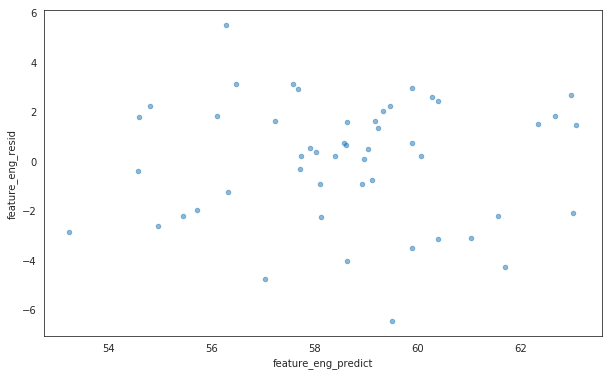

In [32]:
# Add prediction and residual columns to the dataframe
smaller_df['feature_eng_predict'] = new_fit.predict(X)
smaller_df['feature_eng_resid'] = smaller_df['happiness_avg'] - smaller_df.feature_eng_predict
with sns.axes_style('white'):
    plot = smaller_df.plot(
        kind='scatter', x='feature_eng_predict', y='feature_eng_resid', alpha=0.5, figsize=(10,6))

Text(0.5, 1.0, 'Normal Q-Q plot')

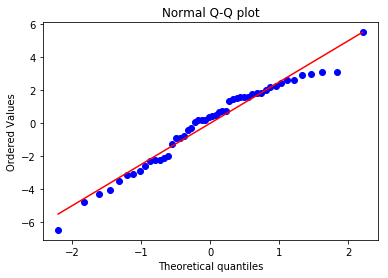

In [33]:
res = smaller_df['happiness_avg'] - smaller_df.feature_eng_predict

stats.probplot(res, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

# Analyze qq-plot